# Galaxy Clusters & Velocity: A HackUrDC2 Story

Author: Julien Peloton [@JulienPeloton](https://github.com/JulienPeloton)  
Last Verifed to Run: 2019-06-11  
Estimated running time: < 30 min.

**Context**

This notebook illustrates the basics of accessing the cosmoDC2 catalog through Apache Spark as well as how to select useful samples of data to study galaxy clusters. 

**Science results or validation?**

While it describes some of the science results you can get with the DC2 catalog (e.g. halo mass-velocity dispersion relation), it shifted towards the validation side, especially on the halo mass distribution. So it is a bit of both! After going through this notebook, you should be able to:

- Load and efficiently access the cosmoDC2 catalog with Apache Spark
- Apply cuts to the catalog using Spark SQL functionalities
- Have several example of quality cuts and validation procedures 
- Derive scientific results on galaxy clusters
- Distribute the computation and the plotting routine to be faster!

**Table of contents:**
- Loading cosmoDC2 data with Apache Spark
- Halo mass distribution
  - issue: https://github.com/LSSTDESC/DC2-analysis/issues/55
- Galaxy clusters and velocity
  - A few individual galaxy clusters
  - A wider region of space
  - Mean velocity as a function of redshift
- The velocity dispersion–halo mass relation
  - issue: https://github.com/LSSTDESC/DC2-analysis/issues/57
- Visualising masses in the cosmoDC2 Universe
- Outro: Towards large data sets with Apache Spark

**Logistics:** 

This notebook is intended to be run through the JupyterHub NERSC interface with the desc-pyspark kernel. The kernel is automatically installed in your environment when you use the kernel setup script:

```bash
source /global/common/software/lsst/common/miniconda/kernels/setup.sh
```

**Thanks to:**

[@aphearin](https://github.com/aphearin), [@cwwalter](https://github.com/cwwalter), [@dkorytov](https://github.com/dkorytov), [@rmandelb](https://github.com/rmandelb), [@salmanhabib](https://github.com/salmanhabib), [@yymao](https://github.com/yymao), for their help in understanding better how DC2 catalog was made, and solving issues while making this notebook!

In [1]:
from typing import Iterator, Generator, Any

import numpy as np
import pandas as pd

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import Image

from scipy.optimize import curve_fit

from pyspark.sql.functions import pandas_udf , PandasUDFType
from pyspark.sql import functions as F
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession

## Loading DC2 data with Spark

Apache Spark has no efficient PySpark connector to read data in hdf5 file. Therefore we first converted the cosmoDC2 data set into parquet (similar to what DPDD tools offer). For the purpose of this notebook, we only convert a few columns of interest. The file is accessible at NERSC for DESC members. **Note: the input data has been modified for the notebook to be played outside of DESC. As we use a mock data set, the scientific results are no more relevant and should be left on aside. Only performances are of interest here.**

In [2]:
# Path to the full data set - 27 GB
# fn = "/global/cscratch1/sd/peloton/cosmodc2/xyz_v1.1.4_mass_and_maguniform_mock.parquet"

# For one part only (1.6 GB)
fn = "/global/cscratch1/sd/peloton/cosmodc2/xyz_v1.1.4_mass_and_maguniform_mock.parquet/part-00006-3b01825c-8fc3-4768-a5db-0f6306deba46-c000.snappy.parquet"

# Load the data - this a lazy operation, no data movement yet!
spark = SparkSession.builder.getOrCreate()
df = spark.read.format("parquet").load(fn)

# Let's inspect the schema
df.printSchema()

# Number of objects in the catalog
print("Number of rows: {}".format(df.count()))

root
 |-- velocity_x_mock: float (nullable = true)
 |-- halo_mass_mock: float (nullable = true)
 |-- spheroidMassStellar_mock: float (nullable = true)
 |-- mag_u_mock: float (nullable = true)
 |-- mag_i_mock: float (nullable = true)
 |-- position_x_mock: float (nullable = true)
 |-- halo_id_mock: long (nullable = true)
 |-- is_central_mock: boolean (nullable = true)
 |-- position_z_mock: float (nullable = true)
 |-- totalMassStellar_mock: float (nullable = true)
 |-- hostHaloMass_mock: float (nullable = true)
 |-- stellar_mass_mock: float (nullable = true)
 |-- velocity_z_mock: float (nullable = true)
 |-- stellar_mass_disk_mock: float (nullable = true)
 |-- diskMassStellar_mock: float (nullable = true)
 |-- position_y_mock: float (nullable = true)
 |-- ra_mock: float (nullable = true)
 |-- baseDC2/target_halo_mass_mock: float (nullable = true)
 |-- redshift_mock: float (nullable = true)
 |-- dec_mock: float (nullable = true)
 |-- velocity_y_mock: float (nullable = true)
 |-- mag_g_moc

Let's have a look a some mass values. Apache Spark provides filter mechanisms, which you can use to speed up data access if you only need a certain chunks of the dataset:

In [3]:
# We reject synthetic halos - see for example discussion in 
# https://github.com/LSSTDESC/cosmodc2/issues/82
cols = ["halo_mass_mock", "stellar_mass_mock", "blackHoleMass_mock", "halo_id_mock"]
df.filter("halo_id_mock > 0").select(cols).show(5)

+--------------+-----------------+------------------+------------+
|halo_mass_mock|stellar_mass_mock|blackHoleMass_mock|halo_id_mock|
+--------------+-----------------+------------------+------------+
| 3.41145666E13|    2.26812805E11|      1.70700659E9|       97487|
| 1.86805555E13|    1.71080417E10|      2.70738784E8|   100097487|
| 1.67006972E13|    1.87104936E11|      3.69125728E8|   200097487|
| 2.75283978E13|    1.07626201E11|       5.3018352E8|   400097487|
| 1.19309274E13|      8.5733181E9|      1.89831232E9|   500097487|
+--------------+-----------------+------------------+------------+
only showing top 5 rows



Note that `halo_mass` is duplicated for all the members of the same halo. 
We can also easily look at statistics about individual columns:

In [4]:
# Let's look at the stellar_mass and halo_mass distributions
df.select(["stellar_mass_mock", "halo_mass_mock", "redshift_mock"]).describe().show(5)

+-------+--------------------+--------------------+------------------+
|summary|   stellar_mass_mock|      halo_mass_mock|     redshift_mock|
+-------+--------------------+--------------------+------------------+
|  count|            17248794|            17248794|          17248794|
|   mean|4.596707840723922E10|4.540276404253013E12|1.8699878595517445|
| stddev|1.072054643914478...|1.854287593021663E13|0.7108180860569678|
|    min|           19544.857|         6.3097247E9|       0.009323628|
|    max|       2.02725052E12|       4.51339289E14|         3.0957968|
+-------+--------------------+--------------------+------------------+



For more about Apache Spark in the context of LSST DESC, see e.g. [LSSTDESC/DC2-production](https://github.com/LSSTDESC/DC2-production/tree/master/Notebooks), [LSSTDESC/DC2-analysis](https://github.com/LSSTDESC/DC2-analysis/blob/master/tutorials/object_spark_1_intro.ipynb), [LSSTDESC/desc-spark](https://github.com/LSSTDESC/desc-spark), or connect to [AstroLab Software](https://astrolabsoftware.github.io/)!

## Halo mass distribution in DC2

To start this journey, let's look at the distribution of halo masses in the DC2 data set.
We will select only clusters with positive halo-ids (i.e. we reject the synthetic halos that are added to host the ultra-faint galaxies). In addition, we will create two other populations: low-z (0.0 < z < 0.2), and high-z (2.5 < z < 3.1) clusters.

In [5]:
# We cache the data for speeding up later computations
df_mass = df.filter('is_central_mock == True').filter("halo_id_mock > 0").select("halo_mass_mock").cache()

# Populations based on redshift range
df_mass_lowz = df_mass.filter("redshift_mock < 0.2")
df_mass_highz = df_mass.filter("redshift_mock > 2.5")

Since the number of clusters is rather high, we will capitalize on the fact that we are doing computation in parallel.
The way to be faster is to distribute the computation which leads to the data to be plotted. Histograms are particularly easy to distribute:
- Load the data set across several partitions. Each partition has about 128 MB of data.
- Apply filters on lines and select columns (order does not matter as Spark will choose the optimal way). Partitions will be processed in parallel. If you have more partitions than workers (typically CPU), there will be a partition queue.
- With the remaining data in each partition, build an histogram per partition.
- Reduce to the driver all partition histograms by summing them up. You have the final histogram!

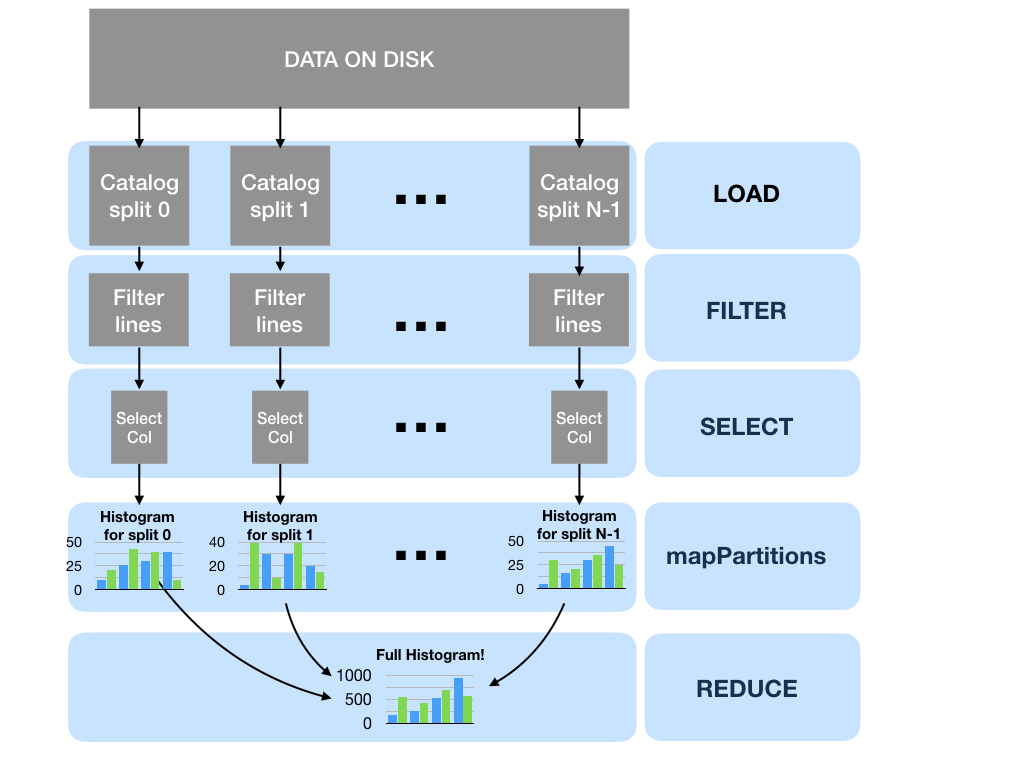

In [6]:
# Illustration of the text above
Image('histo_spark.png')

Let's write such a method to be applied on each Spark partition to compute histograms in parallel (each would contain only a fraction of the data):

In [7]:
def partition_hist(partition: Iterator, bins : np.ndarray = None) -> Generator:
    """ Produce histograms from partition data
    
    Parameters
    ----------
    partition : Iterator
        Iterator containing partition data *[x].
        
    Returns
    ----------
    Generator yielding histograms for each partition. 
    Counts is an array of dimension nbins - 1.
    """
    # Unwrap the iterator
    mass = [*partition]
    
    (counts, edges) = np.histogram(mass, bins)
    
    yield counts

def parallel_hist(df: DataFrame, bins : np.ndarray, col: str = None) -> np.ndarray:
    """ Build an histogram of the data in parallel
    
    Parameters
    ----------
    df : DataFrame
        Apache Spark DataFrame.
    bins : 1D numpy array
        The bin edges, including the rightmost edge.
    col : str, optional
        Column to select. If None, the DataFrame is
        expected to have only one column. Default is None.
        
    Returns
    ----------
    hist : 1D numpy array
        Full histogram over `bins` for the selected DataFrame column.
        hist has dimension len(bins) - 1.

    """
    # Go from DataFrame to RDD world
    if col is None:
        rdd = df.rdd
    else:
        rdd = df.select(col).rdd
        
    # Build the histograms in each partition
    hist = rdd\
        .mapPartitions(lambda partition: partition_hist(partition, bins))\
        .reduce(lambda x, y: x+y)

    return hist

# Binning of mass in log space
bins = np.logspace(8, 15, 50)

# Build histograms for the 3 populations
dataplot = []
for index, dataframe in enumerate([df_mass, df_mass_lowz, df_mass_highz]):
    # This is the crucial part - build the plot data in parallel, and
    # reduce the final result to the driver. Scalable to Billions of points!
    dataplot.append(parallel_hist(dataframe, bins))

Entries for All redshifts : 1861178 (100.0%)
Entries for 0.0 < z < 0.2 : 4920 (0.3%)
Entries for 2.5 < z < 3.1 : 357161 (19.2%)


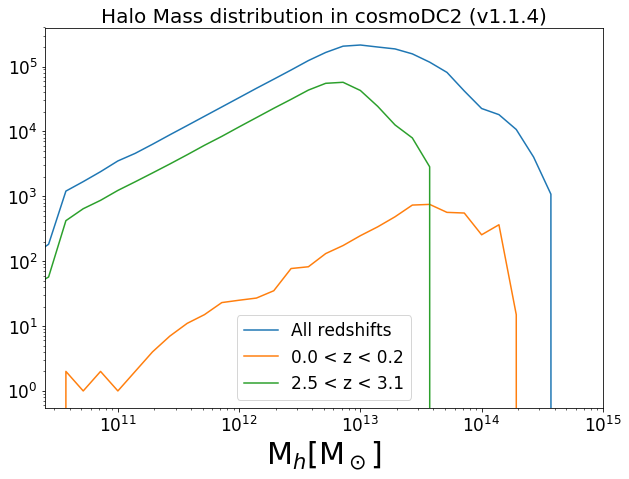

In [8]:
# Plot the result
matplotlib.rcParams.update({'font.size': 17})
labels = ["All redshifts", "0.0 < z < 0.2", "2.5 < z < 3.1"]

fig = plt.figure(figsize=(10, 7))
for index in range(len(dataplot)):
    plt.loglog(bins[:-1], dataplot[index], label=labels[index])
    print('Entries for {} : {} ({:.1f}%)'.format(
        labels[index], 
        np.sum(dataplot[index]), 
        np.sum(dataplot[index])/np.sum(dataplot[0])*100))
plt.legend()

plt.xlim(2.5e10, 1e15)
plt.title('Halo Mass distribution in cosmoDC2 (v1.1.4)', fontsize=20)
plt.xlabel(r'${\rm M}_h [{\rm M}_\odot]$', fontsize=30)
plt.show()

### A weird feature!

We selected the clusters based on their `halo_id`, and to avoid double counting we took only entries corresponding to central galaxies (all galaxies for a given `halo_id` have the same `halo_mass`).

If now we look closely at the `halo_mass` distribution values, we observe a weird feature:

In [9]:
df1 = df.filter('is_central_mock == True').filter("halo_id_mock > 0").select('halo_mass_mock')
df2 = df.filter('is_central_mock == True').filter("halo_id_mock > 0").select('halo_mass_mock').distinct()

print("All halo_mass values: {}".format(df1.count()))
print("All distinct halo_mass values: {}".format(df2.count()))

All halo_mass values: 1861178
All distinct halo_mass values: 1826612


There many different halos (i.e. different position on sky) with exactly the same mass! Note that we already select central galaxies to grab the value of the halo mass. Let's look at both distributions:

In [10]:
# Build plots in parallel - millions of points!
data1 = parallel_hist(df1, bins)
data2 = parallel_hist(df2, bins)

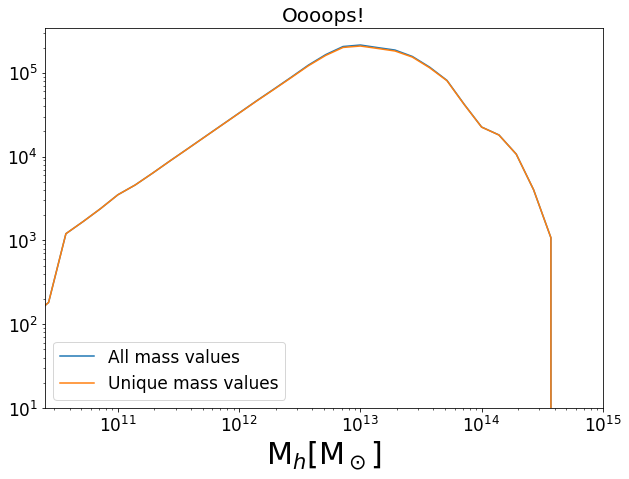

In [11]:
# Plot the result
matplotlib.rcParams.update({'font.size': 17})
plt.figure(figsize=(10, 7))
plt.loglog(bins[:-1], data1, label="All mass values")
plt.loglog(bins[:-1], data2, label="Unique mass values")
plt.title("Oooops!", fontsize=20)
plt.xlim(2.5e10, 1e15)
plt.xlabel(r'${\rm M}_h [{\rm M}_\odot]$', fontsize=30)
plt.legend()
plt.show()

That means many halos with mass lower than $10^{13} {\rm M}_\odot$ have the same mass.

**Question**: Is that expected?

**Answer:** Yes! This is the so-called mass quantization in N-body simulations: all halo masses must by definition be some integer times the particle mass value used in the simulations (a few times 10^9 solar masses). For a detailed discussion, see https://github.com/LSSTDESC/DC2-analysis/issues/55. OK, this one was easy to solve...!

## Galaxy clusters and velocity in DC2

### A few individual galaxy clusters

Let's now focus on some selected galaxy clusters. We will select 5 rich ones ($n_{gal} > 50$), and look at their spatial morphology (in comoving cartesian coordinates), plus the 3D velocity of their members.

In [12]:
# We reject synthetic halos - see for example discussion in 
# https://github.com/LSSTDESC/cosmodc2/issues/82
df_halo = df.filter("halo_id_mock > 0")

# Group by halo_id, and count members
df_halo_grouped = df_halo.groupBy("halo_id_mock").count().filter("count > 50")
df_halo_grouped.show(5)

# Take the 5 first
halos = df_halo_grouped.select("halo_id_mock").take(5)

+-------------+-----+
| halo_id_mock|count|
+-------------+-----+
| 285100097365|   55|
|2834000097203|   70|
|  43300097365|   92|
|  87200097331|   85|
|  84300097171|   57|
+-------------+-----+
only showing top 5 rows



We will collect halos data into Pandas DataFrame. Why using Pandas? to show that you can go from Spark world to Pandas world easily (and also for fun):

In [13]:
# Select position, velocity, stellar mass and redshift
cols_3d = [
    "position_x_mock", "position_y_mock", "position_z_mock", 
    "velocity_x_mock", "velocity_y_mock", "velocity_z_mock"
]
cols = cols_3d + ["stellar_mass_mock", "halo_mass_mock", "redshift_mock"]
pandas_dfs = []
for halo in halos:
    # Keep only members of the halo
    halo_id = np.array(halo)[0]
    df_members = df_halo.filter("halo_id_mock == {}".format(halo_id)).select(cols)
    
    # Halo members
    pandas_df = df_members.toPandas()
    
    # Central galaxy
    pandas_df_center = df_members.filter("is_central_mock == True").toPandas()
    
    pandas_dfs.append([pandas_df, pandas_df_center])

Note however that `toPandas()` sends back the data from all the executors to the lonely poor driver. So be careful to not use that on TB of data!

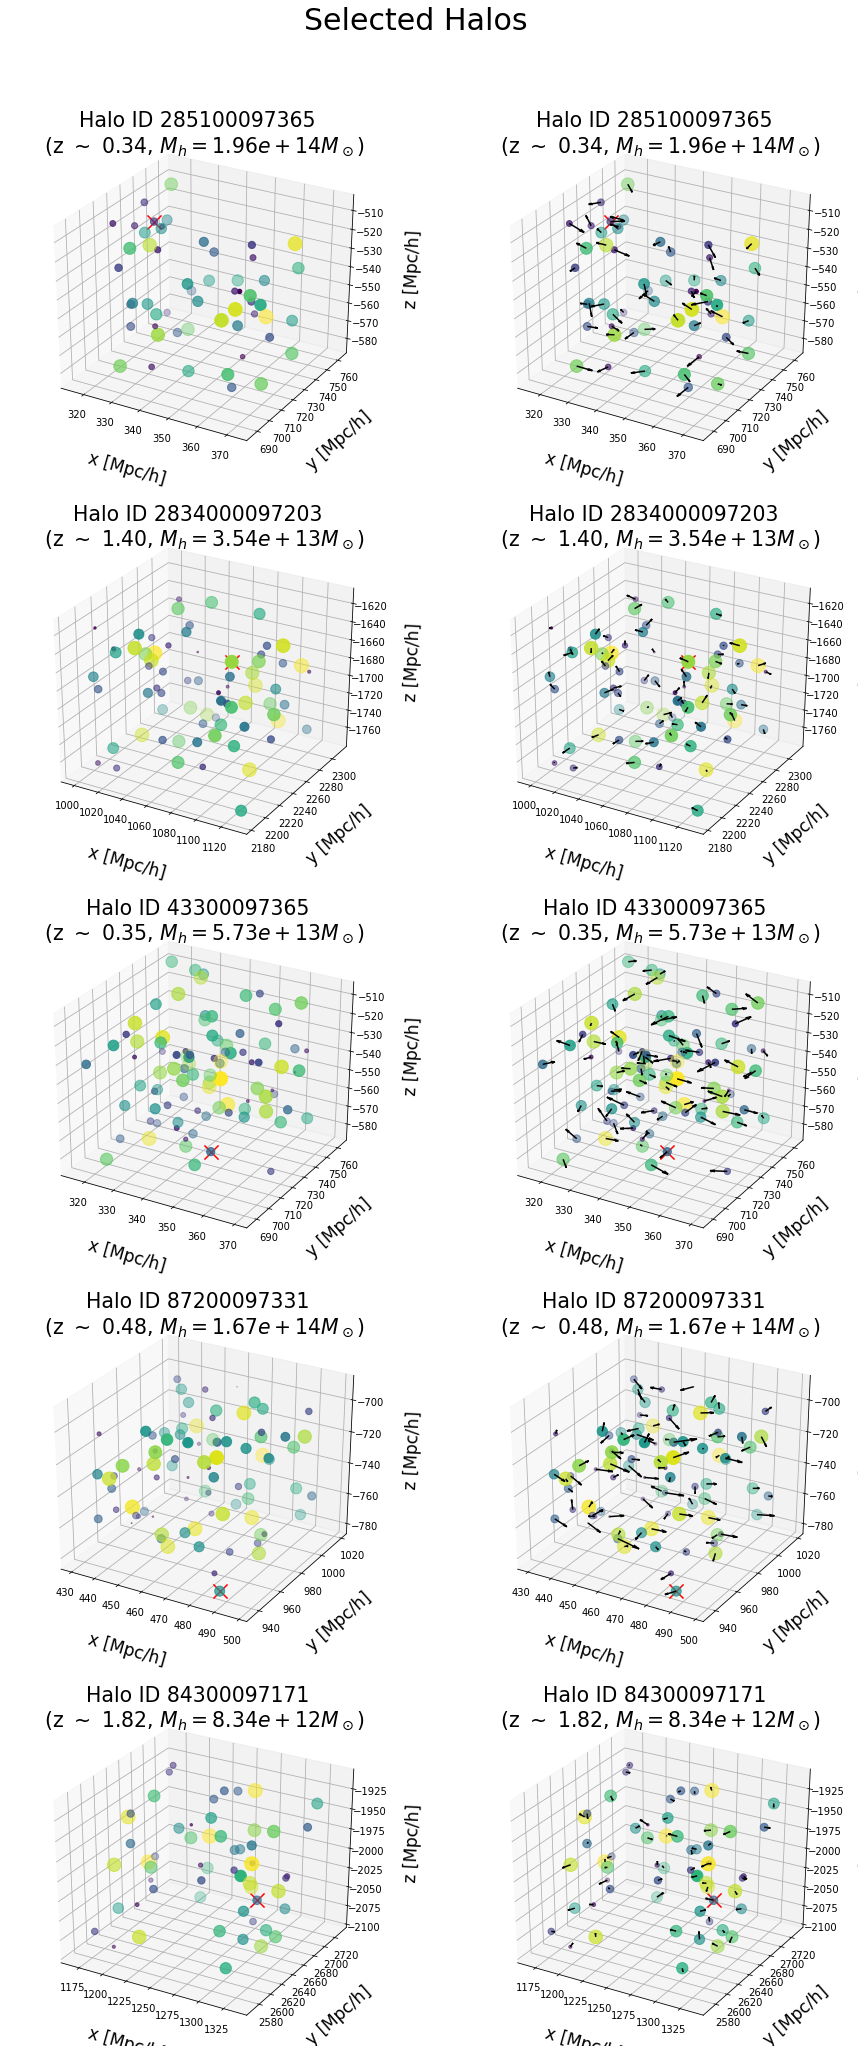

In [14]:
matplotlib.rcParams.update({'font.size': 17})
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15, 35))
fig.suptitle('Selected Halos', y=0.93, fontsize=30)

for index, halo, pdfs in zip(range(len(halos)), halos, pandas_dfs):
    
    # First plot column: position of members, color coded with stellar mass
    ax = fig.add_subplot(5, 2, 2*index + 1, projection='3d')
    mass_scale = pdfs[0].stellar_mass_mock / pdfs[0].stellar_mass_mock.max() * 200
    halo_id = np.array(halo)[0]
    zmean = pdfs[1].redshift_mock.mean()
    halo_mass = pdfs[1].halo_mass_mock.mean()
    
    ax.scatter(
        pdfs[0].position_x_mock, 
        pdfs[0].position_y_mock, 
        pdfs[0].position_z_mock, s=mass_scale, c=mass_scale)
    ax.scatter(
        pdfs[1].position_x_mock, 
        pdfs[1].position_y_mock, 
        pdfs[1].position_z_mock, 
        s=200, color="red", marker="x")
    ax.set_title(
        'Halo ID {} \n (z $\sim$ {:.2f}, $M_h = {:.2e} M_\odot$)'.format(
            halo_id, zmean, halo_mass))
    ax.set_xlabel(r'x [Mpc/h]', labelpad=20)
    ax.set_ylabel(r'y [Mpc/h]', labelpad=20)
    ax.set_zlabel(r'z [Mpc/h]', labelpad=20)
    ax.tick_params(axis='both', labelsize=10)

    # Second plot column: position of members + 3D velocity, 
    # color coded with stellar mass.
    ax = fig.add_subplot(5, 2, 2*index + 2, projection='3d')
    ax.scatter(
        pdfs[0].position_x_mock, 
        pdfs[0].position_y_mock, 
        pdfs[0].position_z_mock, s=mass_scale, c=mass_scale)
    q = ax.quiver(
        pdfs[0].position_x_mock, 
        pdfs[0].position_y_mock, 
        pdfs[0].position_z_mock, 
        pdfs[0].velocity_x_mock, 
        pdfs[0].velocity_y_mock, 
        pdfs[0].velocity_z_mock, length=0.002, color='k')
    ax.scatter(
        pdfs[1].position_x_mock, 
        pdfs[1].position_y_mock, 
        pdfs[1].position_z_mock, 
        s=200, color="red", marker="x")
    ax.set_title(
        'Halo ID {} \n (z $\sim$ {:.2f}, $M_h = {:.2e} M_\odot$)'.format(
            halo_id, zmean, halo_mass))
    ax.set_xlabel(r'x [Mpc/h]', labelpad=20)
    ax.set_ylabel(r'y [Mpc/h]', labelpad=20)
    ax.set_zlabel(r'z [Mpc/h]', labelpad=20)
    ax.tick_params(axis='both', labelsize=10)
plt.show()

Color code: 
- yellow = big = more massive, 
- purple = small = less massive

Note that for the 2nd and 4th halos the velocities seem to be aligned along an axis as if they were following some flow. 
On the third halo, galaxies seem to rotate around the center. 

### A wider region of space

Let's have a look at a wider region of space. We focus on a cube of 15 Mpc size (~ 2000 halos), compute and display the mean velocity for each halo:

In [15]:
# Select columns of interest
cols = ["halo_id_mock", "position_x_mock", "position_y_mock", "position_z_mock", "redshift_mock", "is_central_mock"]
cols_vel = ["velocity_x_mock", "velocity_y_mock", "velocity_z_mock"]
cols_mass = ["halo_mass_mock"]
df_sub = df.select(cols + cols_mass + cols_vel).filter("halo_id_mock > 0")

In [16]:
# Get the mean position of our cube of data
df_stat = df_sub.select(["position_x_mock", "position_y_mock", "position_z_mock"]).describe()
means = df_stat.collect()[1]

m_x = float(means['position_x_mock'])
m_y = float(means['position_y_mock'])
m_z = float(means['position_z_mock'])

In [17]:
# Size of our data cube
Mpc = 15.

# Keep only this region of space
dfcut = df_sub.filter(
    (F.abs(df_sub.position_x_mock - m_x) < Mpc) &
    (F.abs(df_sub.position_y_mock - m_y) < Mpc) &
    (F.abs(df_sub.position_z_mock - m_z) < Mpc))

In [18]:
# Group data by halos and compute the mean velocity
df_disp = dfcut.groupBy("halo_id_mock").agg({
    "velocity_x_mock": 'mean',
    "velocity_y_mock": 'mean',
    "velocity_z_mock": 'mean'})

# Add back original columns, and 
# select only a few columns for the plot
data_joined = dfcut.join(df_disp, "halo_id_mock")\
    .filter("is_central_mock == True")\
    .select(
    "avg(velocity_x_mock)", "avg(velocity_y_mock)", 'avg(velocity_z_mock)', 
    "position_x_mock", "position_y_mock", "position_z_mock", 
    'redshift_mock', 'halo_mass_mock')

# Show a few columns 
data_joined.show(5)

# Go to Pandas world for the plot
pandas_df = data_joined.toPandas()

+--------------------+--------------------+--------------------+---------------+---------------+---------------+-------------+--------------+
|avg(velocity_x_mock)|avg(velocity_y_mock)|avg(velocity_z_mock)|position_x_mock|position_y_mock|position_z_mock|redshift_mock|halo_mass_mock|
+--------------------+--------------------+--------------------+---------------+---------------+---------------+-------------+--------------+
|    2606.61181640625|   -2379.24755859375|    2042.94091796875|       1151.954|      2453.9988|     -1861.9067|     1.577909| 1.47666135E13|
|   -2847.69091796875|  -398.7684020996094|  -3027.275146484375|      1178.6492|      2463.8289|     -1845.6213|    1.6948136|  5.0242049E13|
| -1772.2330322265625|    -315.41064453125|         -3663.40625|      1151.9282|        2452.54|     -1837.6056|    1.6010903|  3.5475151E13|
|   2521.094970703125|  -727.4666748046875|  -2650.687255859375|      1175.1117|       2453.914|     -1860.9983|    1.6562829|  7.4105105E12|
|   31

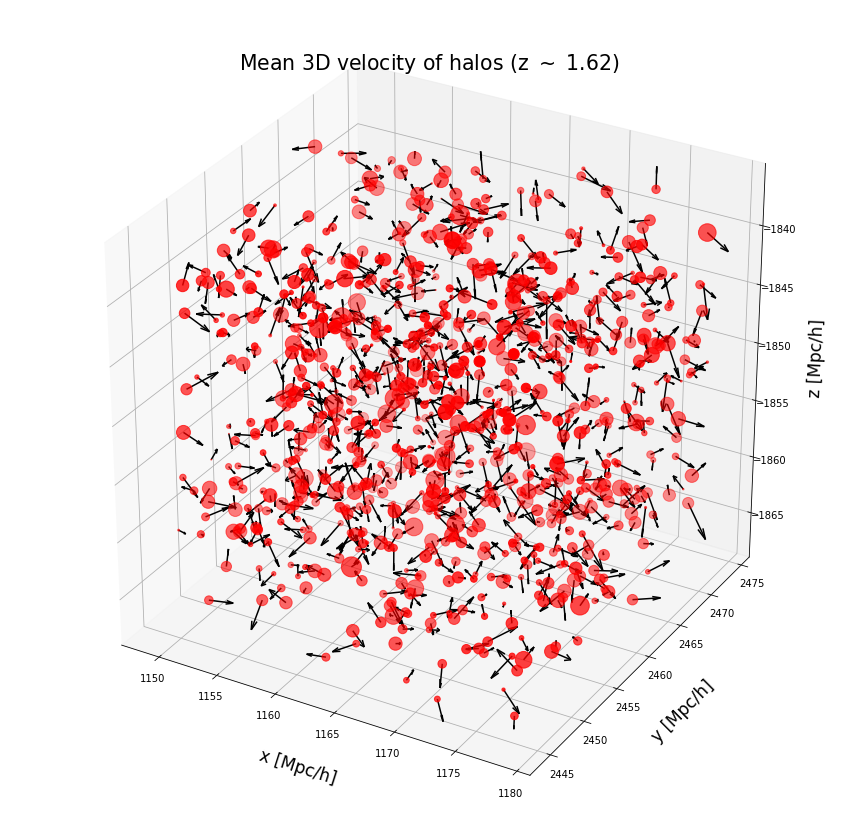

In [19]:
matplotlib.rcParams.update({'font.size': 17})

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1, projection='3d')
q = ax.quiver(
    pandas_df.position_x_mock, 
    pandas_df.position_y_mock, 
    pandas_df.position_z_mock, 
    pandas_df["avg(velocity_x_mock)"], 
    pandas_df["avg(velocity_y_mock)"], 
    pandas_df["avg(velocity_z_mock)"], length=0.0005, color='k')
ax.scatter(
    pandas_df.position_x_mock, 
    pandas_df.position_y_mock, 
    pandas_df.position_z_mock, 
    s=pandas_df.halo_mass_mock/pandas_df.halo_mass_mock.max()*400, c='r')
plt.title(
    'Mean 3D velocity of halos (z $\sim$ {:.2f})'.format(pandas_df.redshift_mock.mean()))
ax.set_xlabel(r'x [Mpc/h]', labelpad=20)
ax.set_ylabel(r'y [Mpc/h]', labelpad=20)
ax.set_zlabel(r'z [Mpc/h]', labelpad=20)
ax.tick_params(axis='both', labelsize=10)
plt.show()

We show the 3D mean velocity (black arrow) for each halo contained in this data cube (15 Mpc size). We also superimposed the halo mass (red circle). The bigger is the circle, the more massive is the halo. It is interesting to notice that most massive halos are surrounded by halos with large velocities, they seem to flow towards them.

With more times, that would be interesting to study other properties and the environment of those halos and see whether there is a correlation with the velocities.

### Mean velocity as a function of redshift

To end this journey, let's have a look at the mean velocity distribution as a function of redshift:

In [20]:
# Redshift range
redshift_start = 0.0
redshift_stop = 3.0
redshift_step = 0.5
redshift_window = 0.1
values = np.arange(redshift_start, redshift_stop, redshift_step)

# start at 0.2 because stat is poor at very low redshift
values[0] = 0.2

In [21]:
pdfs = []
for index, start in enumerate(values[:]):
    dfcut = df_sub.filter("redshift_mock > {}".format(start))\
        .filter("redshift_mock <= {}".format(start + redshift_window))
    
    # Group data by halos and compute the mean velocity
    df_disp = dfcut.groupBy("halo_id_mock").agg({
        "velocity_x_mock": 'mean',
        "velocity_y_mock": 'mean',
        "velocity_z_mock": 'mean'})

    # Add back original columns, and 
    # select only a few columns for the plot
    data_joined = dfcut.join(df_disp, "halo_id_mock")\
        .filter("is_central_mock == True")\
        .select("avg(velocity_x_mock)", "avg(velocity_y_mock)", 'avg(velocity_z_mock)')
    pdfs.append(data_joined.toPandas())

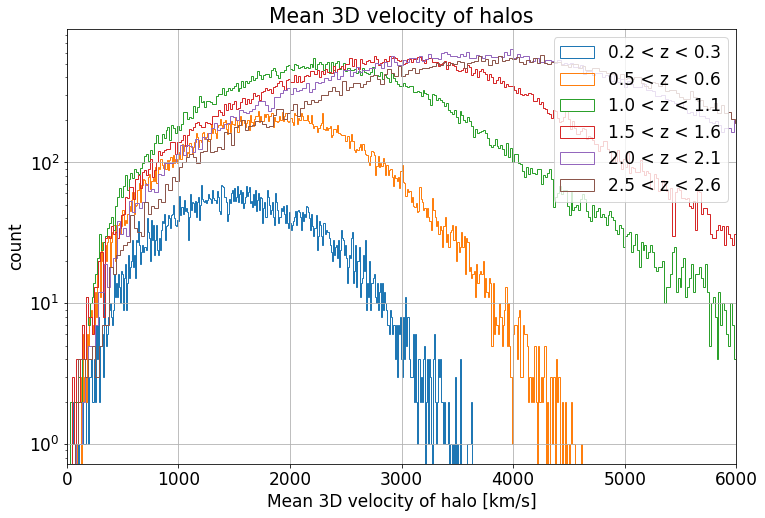

In [22]:
matplotlib.rcParams.update({'font.size': 17})
fig = plt.figure(figsize=(12, 8))

plt.title("Mean 3D velocity of halos")
for index, pandas_df in enumerate(pdfs):
    # simple mean
    meanv = np.sqrt(
        pandas_df["avg(velocity_x_mock)"]**2 + 
        pandas_df["avg(velocity_y_mock)"]**2 + 
        pandas_df["avg(velocity_z_mock)"]**2)
    
    # histogram
    plt.hist(
        meanv, bins=400, 
        label="{:.1f} < z < {:.1f}".format(values[index], values[index] + redshift_window), 
        histtype="step")

plt.yscale("log")
plt.xlim(0, 6000)

plt.xlabel("Mean 3D velocity of halo [km/s]")
plt.ylabel("count")

plt.legend()
plt.grid()

plt.show()

It is interesting to notice that the peak of the distribution shifts towards larger values for high redshift. The distributions are also broader at high redshift.

## The velocity dispersion–halo mass relation

In this section we compute the velocity dispersion–halo mass relation. The principle is similar to the M-$\sigma$ relation for stars around black holes. The idea is to highlight the fact that gravitational interaction/friction between galaxies has an effect for the cluster galaxy evolution.

In [23]:
from pyspark.sql.functions import stddev_pop

@pandas_udf('double', PandasUDFType.SCALAR)
def normv(vx: Any, vy: Any, vz: Any) -> pd.Series:
    """ Compute the 3D velocity norm.
    
    To be used as a User Defined Function for Spark.
    
    Parameters
    ----------
    v{i} : 1D array, or string, or DataFrame column
        Velocity data
    
    Returns
    ----------
    One-dimensional ndarray with axis labels (including time series).
    """
    v = np.sqrt(vx**2 + vy**2 + vz**2)
    return pd.Series(v)

# We reject synthetic halos - see for example discussion in 
# https://github.com/LSSTDESC/cosmodc2/issues/82
# In addition we select halo members with stellar mass > 5e10 M_o.
df_filt = df.filter("halo_id_mock > 0").filter("stellar_mass_mock > 5e10")

# Add a column which is the 3D velocity norm
df_meanv = df_filt\
    .withColumn("normv", normv("velocity_x_mock", "velocity_y_mock", "velocity_z_mock"))\
    .select(["normv", "halo_mass_mock", "is_central_mock", "halo_id_mock", "redshift_mock"])

# Group data by halos and compute the velocity dispersion
df_disp = df_meanv.groupBy("halo_id_mock").agg(stddev_pop("normv").alias("stdv"))

In [24]:
# Add back the original DataFrame columns
# and select only central member for halo 
# (unique halo mass and velocity dispersion for a halo)
data_joined = df_meanv.join(df_disp, "halo_id_mock")\
    .filter("is_central_mock == True")\
    .filter("stdv > 0")\
    .select("stdv", "halo_mass_mock", 'redshift_mock')\
    .dropna()
data_joined.show(5)

# Collect the data from the executors to the driver
data = data_joined.collect()

+------------------+--------------+-------------+
|              stdv|halo_mass_mock|redshift_mock|
+------------------+--------------+-------------+
|122.58184814453125|  5.9342817E12|   0.45994464|
|1257.3661848155605| 2.68840018E13|    1.6481768|
|  243.925048828125| 1.21009655E12|    1.8021337|
|268.24786376953125| 1.47063057E13|    0.6916351|
|150.87420654296875| 1.95408723E13|  0.089364015|
+------------------+--------------+-------------+
only showing top 5 rows



In [25]:
vel, mass, redshift = np.transpose(data)
print("Number of entries: {}".format(len(vel)))

Number of entries: 211134


Let's now plot the velocity dispersion vs halo mass

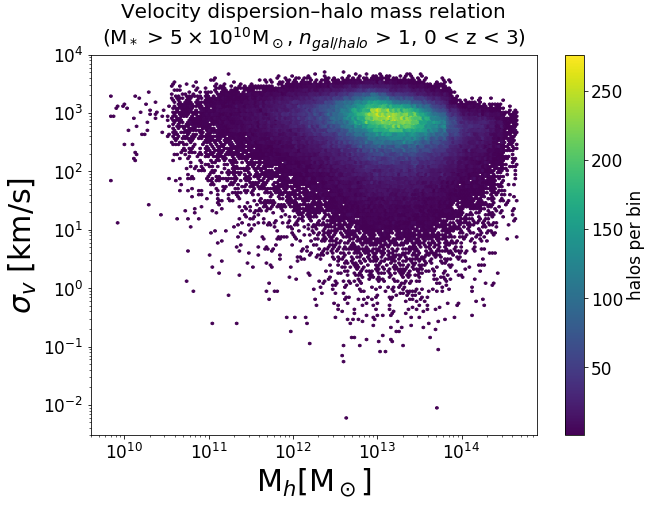

In [26]:
matplotlib.rcParams.update({'font.size': 17})
fig = plt.figure(figsize=(10, 7))

cs = plt.hexbin(mass, vel, gridsize=150, xscale="log", yscale="log", mincnt=1)

plt.xlabel(r'${\rm M}_h [{\rm M}_\odot]$', fontsize=30)
plt.ylabel(r'$\sigma_v$ [km/s]', fontsize=30)

plt.colorbar(cs, label="halos per bin")

title = "Velocity dispersion–halo mass relation\n"
hypotheses = r"(${\rm M}_*$ > $5\times10^{10}{\rm M}_\odot$, $n_{gal/halo}$ > 1, 0 < z < 3)"
plt.title(title + hypotheses, fontsize=20)

plt.show()

One can see that there is a good relationship between the two. One can also see regular stripes at some halo masses. Let's inspect the 1D mass distribution:

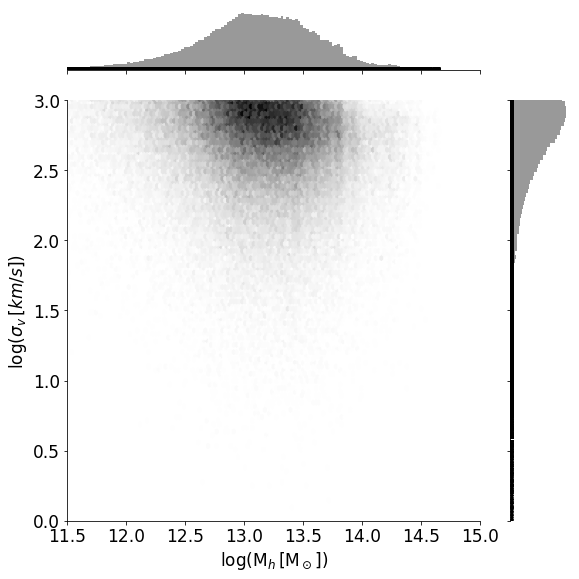

In [27]:
# Let's inspect these stripes
import seaborn as sns

joint_kws = dict(gridsize=200, mincnt=1)
g = sns.jointplot(
    np.log10(mass), 
    np.log10(vel), 
    height=8, space=0.5,
    kind='hex', xlim=(11.5, 15), ylim=(0, 3), color='k',
    joint_kws=joint_kws, 
    marginal_kws=dict(bins=200, rug=True))

g.set_axis_labels(r'$\log({\rm M}_h \, [{\rm M}_\odot])$', r'$\log(\sigma_v \, [km/s])$')

plt.show()

Hum, the peaks in the 1D halo mass distribution seem to be regularly spaced in log space. In order to study more in details this effect, I created another notebook: [hackurdc2_spark_halos_appendix.ipynb](https://github.com/LSSTDESC/DC2-analysis/blob/u/JulienPeloton/hackurdc2_spark_halos/contributed/hackurdc2_spark_halos_appendix.ipynb). This is also discussed in detailed in [LSSTDESC/DC2-analysis/issues/57](https://github.com/LSSTDESC/DC2-analysis/issues/57).

Long story short: The tooth shape is expected from how galaxies in the Universe Machine are sampled into the Outer Rim halo light cone. This will put a limit on the accuracy with which cosmoDC2 observations could constrain the halo mass of stacked galaxy sample, and future simulations may implement a bin-free sampling method instead.

### Fitting the data

Following e.g. [1602.00611](https://arxiv.org/abs/1602.00611) (see section 4.1), we can model the mean relation between velocity dispersion and halo mass at a given redshift using a simple power-law of the form:

$$\sigma_v(\rm{M}_h) = \alpha \Big( \dfrac{\rm{M}_h}{10^{14}\rm{M}_\odot} \Big)^{\beta}$$

and the dependency in redshift is given by

$$\sigma_v(z) = \sigma_v(0)\sqrt{1 + z}$$

Let's split our data set into redshit bins, and fit for the coefficients:

/global/common/software/lsst/common/miniconda/current/lib/python3.6/site-packages/ipykernel/__main__.py:29: RuntimeWarning: overflow encountered in power
/global/common/software/lsst/common/miniconda/current/lib/python3.6/site-packages/ipykernel/__main__.py:29: RuntimeWarning: overflow encountered in multiply


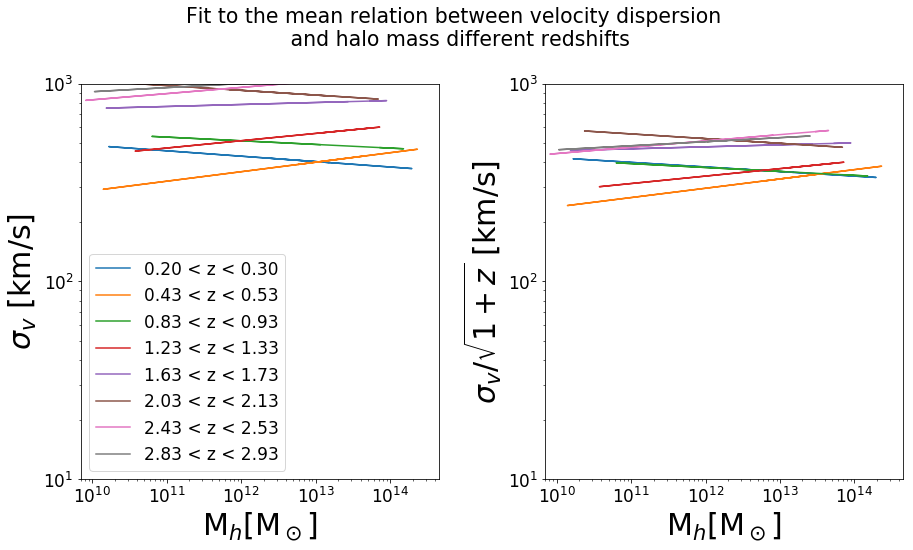

In [28]:
matplotlib.rcParams.update({'font.size': 17})
redshift_start = np.min(redshift)
redshift_stop = 3.0
redshift_step = 0.4
redshift_window = 0.1
values = np.arange(redshift_start, redshift_stop, redshift_step)

# start at 0.2 because stat is poor at very low redshift
values[0] = 0.2

def vel_mass_relation(mass: np.ndarray, a: float, b: float) -> np.ndarray:
    """ Model for the mean relation between velocity dispersion 
    and halo mass at a given redshift using a simple power-law.
    
    The pivot mass is at 10^14 solar mass.
    
    Parameters
    ----------
    mass : 1D numpy array
        List of masses
    a, b: floats
        Coefficient of the power law a*x**b
       
    Returns
    ----------
    out : 1D numpy array
        Velocity dispersion according to the power law.
    """
    return a * (mass / 1e14)**b

# Use for later pretty print of coefficient fit.
table = """
| redshift | $\\alpha$ [km/s] | $\\beta$ | entries (#) |
|----------|------------------|----------|-------------|
"""

fig, ax = plt.subplots(1, 2, figsize=(13, 7))
fig.suptitle("Fit to the mean relation between velocity dispersion \n and halo mass different redshifts", y=1.1)

for index, start in enumerate(values[:]):
    mask = (redshift > start) & (redshift < start + redshift_window)
    
    res = curve_fit(vel_mass_relation, mass[mask], vel[mask])
    val = res[0]
    err = np.diag(res[1])
    table += "{:.2f} < z < {:.2f} | {:.2f} $\pm$ {:.2f} | {:.2E} $\pm$ {:.2E} | {} | \n".format(
        start, start + redshift_window, val[0], err[0], val[1], err[1], np.sum(mask))

    # Plot the fit
    ax[0].loglog(mass[mask], vel_mass_relation(mass[mask], val[0], val[1]), 
                 ls='-', marker='', color="C{}".format(index), 
                 label=r"{:.2f} < z < {:.2f}".format(start, start + redshift_window))
    
    # Rescale with the redshift dependency
    # before fitting.
    res = curve_fit(vel_mass_relation, mass[mask], vel[mask] / np.sqrt(1 + redshift[mask]))
    val = res[0]
    err = np.diag(res[1])
    ax[1].loglog(mass[mask], vel_mass_relation(mass[mask], val[0], val[1]), 
                 ls='-', marker='', color="C{}".format(index),
                 label=r"{:.2f} < z < {:.2f}".format(start, start + redshift_window))
    
    for i in range(2):
        ax[i].set_ylim(10, 1000)
        ax[i].set_xlim(np.min(mass), np.max(mass))
        ax[i].set_xlabel(r'${\rm M}_h [{\rm M}_\odot]$', fontsize=30)
    ax[0].set_ylabel(r'$\sigma_v$ [km/s]', fontsize=30)
    ax[1].set_ylabel(r'$\sigma_v / \sqrt{1 + z}$ [km/s]', fontsize=30)

    ax[0].legend()

plt.tight_layout()
plt.show()

# uncomment below to print coefficient values
# print(table)

This is similar to what is shown in e.g. 1602.00611 in a smaller redshift range (see section 4.1). If we look at the coefficients, $\alpha$s are somewhat similar but there are some differences in $\beta$s (note: on GitHub, the table is not correctly displayed... Try on the JupyterLab interface directly):

| redshift | $\alpha$ [km/s] | $\beta$ | entries (#) |
|----------|-----------|----------|-------------|
0.20 < z < 0.30 | 308.53 $\pm$ 46.48 | 5.17E-01 $\pm$ 2.80E-04 | 691 | 
0.45 < z < 0.55 | 330.33 $\pm$ 28.55 | 5.09E-01 $\pm$ 1.27E-04 | 2231 | 
0.85 < z < 0.95 | 368.03 $\pm$ 40.36 | 5.06E-01 $\pm$ 1.04E-04 | 3506 | 
1.25 < z < 1.35 | 403.02 $\pm$ 83.50 | 5.12E-01 $\pm$ 1.53E-04 | 3200 | 
1.65 < z < 1.75 | 425.80 $\pm$ 193.15 | 5.22E-01 $\pm$ 2.76E-04 | 2236 | 
2.05 < z < 2.15 | 402.48 $\pm$ 626.99 | 4.80E-01 $\pm$ 7.84E-04 | 1237 | 
2.45 < z < 2.55 | 505.46 $\pm$ 2236.88 | 5.57E-01 $\pm$ 1.66E-03 | 698 | 
2.85 < z < 2.95 | 546.90 $\pm$ 6745.14 | 5.54E-01 $\pm$ 3.75E-03 | 346 |

Part of the difference can come from different cuts applied for the minimal mass, or the definition of member galaxies.
We note that the $\alpha$ coefficients are poorly fitted for $z >1.6$. Maybe a different relation takes place at high redshift? Or we need more statistics? Or something else?

However the scaling in redshift ($\sigma_v \propto \sqrt{1 + z}$) seems rather good accross the whole data set!

## Visualising Masses in the DC2 Universe

We usually plot the stellar mass - halo mass relation, or black hole mass - halo mass relation (see for example this [notebook](https://nbviewer.jupyter.org/github/LSSTDESC/DC2-analysis/blob/rendered/tutorials/extragalactic_gcr_mass_relations.nbconvert.ipynb)). Here we propose to visualize it in 3D directly! By visual inspection, one can easily have an intuition of the contribution of stars or black holes to halo masses.

In [29]:
# Select masses
cols = ["halo_id_mock", "position_x_mock", "position_y_mock", "position_z_mock", "redshift_mock"]
cols_mass = ["halo_mass_mock", "stellar_mass_mock", "blackHoleMass_mock"]
df_sub = df.select(cols + cols_mass).filter("halo_id_mock > 0")

In [30]:
# Get the mean position of our cube of data
# (we could also have re-used this from a previous cell)
df_stat = df_sub.select(["position_x_mock", "position_y_mock", "position_z_mock"]).describe()
means = df_stat.collect()[1]

m_x = float(means['position_x_mock'])
m_y = float(means['position_y_mock'])
m_z = float(means['position_z_mock'])

In [32]:
# Size of our data cube
Mpc = 30.

dfcut = df_sub.filter(
    (F.abs(df_sub.position_x_mock - m_x) < Mpc) &
    (F.abs(df_sub.position_y_mock - m_y) < Mpc) &
    (F.abs(df_sub.position_z_mock - m_z) < Mpc))

# Go to Pandas for the plot
df_disp = dfcut.groupBy("halo_id_mock").agg(F.sum("stellar_mass_mock").alias("total_stellar_mass"))
data_joined = dfcut.join(df_disp, "halo_id_mock")
p = data_joined.toPandas()

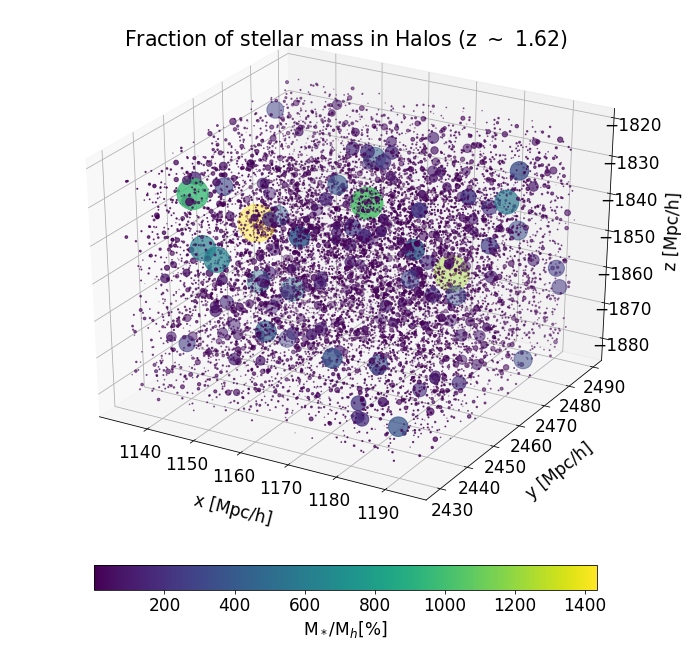

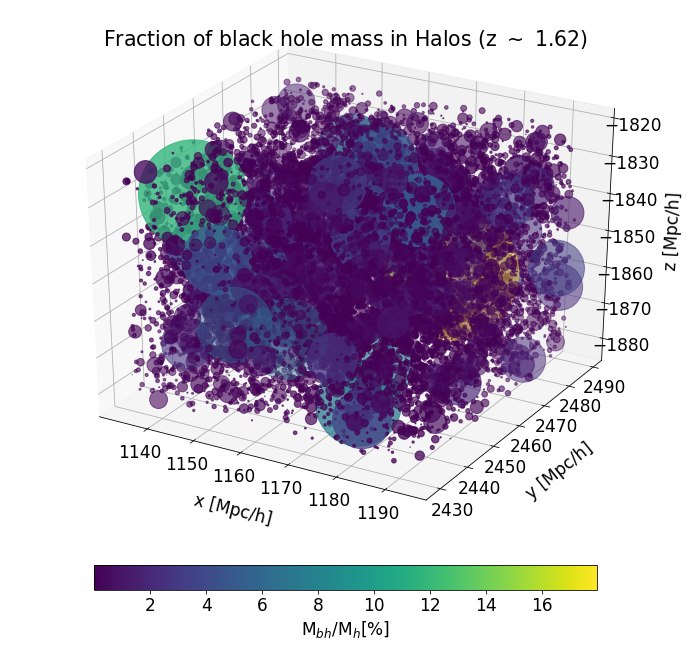

In [34]:
matplotlib.rcParams.update({'font.size': 17})

def fmass(p: pd.DataFrame, which: str) -> pd.Series:
    """ Compute the fraction of mass relative to 
    the halo mass (in %)
    
    Parameters
    ----------
    p : Pandas DataFrame
        Pandas DataFrame
    which : str
        Column name for which we want the ratio
        
    Returns
    ----------
    ratio: pd.Series
        1D array with fractional masses.
    """
    ratio = (p[which] / p['halo_mass_mock']) * 100
    return ratio


# Stellar mass / halo mass
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Fraction of stellar mass in Halos (z $\sim$ {:.2f})'.format(p.redshift_mock.mean()))

c = ax.scatter(
    p.position_x_mock, 
    p.position_y_mock, 
    p.position_z_mock, 
    c=fmass(p, "total_stellar_mass"), 
    s=fmass(p, "total_stellar_mass"))
plt.colorbar(c, shrink=0.75, label=r"${\rm M}_*/{\rm M}_h$[%]", orientation="horizontal", pad=0.05)

ax.set_xlabel(r'x [Mpc/h]', labelpad=20)
ax.set_ylabel(r'y [Mpc/h]', labelpad=20)
ax.set_zlabel(r'z [Mpc/h]', labelpad=20)
plt.show()

# Black hole mass / halo mass
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Fraction of black hole mass in Halos (z $\sim$ {:.2f})'.format(p.redshift_mock.mean()))
c = ax.scatter(
    p.position_x_mock, 
    p.position_y_mock, 
    p.position_z_mock, 
    c=fmass(p, "blackHoleMass_mock"), 
    s=fmass(p, "blackHoleMass_mock")*1000)
plt.colorbar(c, shrink=0.75, label=r"${\rm M}_{bh}/{\rm M}_h$[%]", orientation="horizontal", pad=0.05)

ax.set_xlabel(r'x [Mpc/h]', labelpad=20)
ax.set_ylabel(r'y [Mpc/h]', labelpad=20)
ax.set_zlabel(r'z [Mpc/h]', labelpad=20)

plt.show()

No surprises, most halo masses are not dominated by stellar masses ($< 5$%), and black holes only contribute to a few ($< 0.2$%)! Of course, one could use much better visualisation tools (combined with the power of Spark!), like is done in [hackurdc2_TheMovie/tutorials/cosmoDC2_TheMovie.ipynb](https://github.com/LSSTDESC/DC2-analysis/blob/u/LAL/hackurdc2_TheMovie/tutorials/cosmoDC2_TheMovie.ipynb).

## Outro: Towards large data sets with Apache Spark

In this notebook, we have done science thanks to Apache Spark. Spark, is meant to be primarily used in a context of big data. One of its strength is its scalability, namely its capability of using the same piece of code regardless the underlying data volume. The performance of the code will then only depend on the resource used. E.g. for tasks without communications, execution time will be linear with data or resource.

Keep in mind:

- For small volume of data (< 10 GB), you will certainly hit Spark noise and burning time.
- Spark is written in Scala, which is certainly not as specialised as C++ could be. Therefore for small volume of data, there is a chance an algorithm in Scala (Spark) would be slower than its C++ counterpart. But the Spark one is meant to run on TB of data as it was written for MB of data - which is probably not the case for the C++ code.
- Once the data is loaded, you can decide to keep it in memory (distributed among the executors). The next iterations will then go super fast (typically disk I/O throughput is o(100) MB/s while RAM is o(10) GB/s).

So in this example, the smallish vloume of data is likely to lessen Spark performance (volume is just few tens of GB here), and these tests must also be ran on hundreds of GB of data with many processors!

_More on Spark in the context of DESC can be found at: https://github.com/LSSTDESC/desc-spark_